# Bootstrap Explanations with the German Credit Dataset

In [1]:
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from bootstrap import *

In [2]:
# This code has been adapted from
# https://github.com/dylan-slack/Modeling-Uncertainty-Local-Explainability

PARAMS = {
    'protected_class': 1,
    'unprotected_class': 0,
    'positive_outcome': 1,
    'negative_outcome': 0
}

def get_and_preprocess_german():
    """"Handle processing of German.  We use a preprocessed version of German from Ustun et. al.
    https://arxiv.org/abs/1809.06514.  Thanks Berk!
    Parameters:
    ----------
    params : Params
    Returns:
    ----------
    Pandas data frame X of processed data, np.ndarray y, and list of column names
    """
    PROTECTED_CLASS = PARAMS['protected_class']
    UNPROTECTED_CLASS = PARAMS['unprotected_class']
    POSITIVE_OUTCOME = PARAMS['positive_outcome']
    NEGATIVE_OUTCOME = PARAMS['negative_outcome']

    X = pd.read_csv("datasets//german_processed.csv")
    y = X["GoodCustomer"]

    X = X.drop(["GoodCustomer", "PurposeOfLoan", "OtherLoansAtStore"], axis=1)
    X['Gender'] = [1 if v == "Male" else 0 for v in X['Gender'].values]

    y = np.array([POSITIVE_OUTCOME if p == 1 else NEGATIVE_OUTCOME for p in y.values])
    categorical_features = [0, 1, 2] + list(range(10, X.shape[1]))

    output = {
        "X": X.values,
        "y": y,
        "feature_names": [c for c in X],
        "cat_indices": categorical_features,
    }

    return output


def process_tabular_data_get_model(data):
    """Processes tabular data + trains random forest classifier."""
    X = data['X']
    y = data['y']
    feature_names = data['feature_names']
    print("Features: ")
    print(feature_names)
    
    cat_indices = data['cat_indices']
    continuous_features = [i for i in range(len(feature_names)) if i not in cat_indices]

    xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)
    
    ss = StandardScaler().fit(xtrain[:,continuous_features])
    xtrain_ss = np.copy(xtrain)
    xtest_ss = np.copy(xtest)
    xtrain_ss[:,continuous_features] = ss.transform(xtrain[:,continuous_features])
    xtest_ss[:,continuous_features] = ss.transform(xtest[:,continuous_features])
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(xtrain_ss, ytrain)

    output = {
        "model": rf,
        "feature_names": feature_names,
        "cat_indices": cat_indices, 
        "xtrain": xtrain,
        "xtest": xtest,
        "ytrain": ytrain,
        "ytest": ytest,
        "scaler": ss, 
        "label": 1,
        "train_acc": rf.score(xtrain_ss, ytrain),
        "test_acc": rf.score(xtest_ss, ytest)
    }
    
    print("\n# training samples: ", xtrain.shape[0])
    print("# test samples:     ", xtest.shape[0])
    
    print("\n")
    print(f"Train accuracy: {output['train_acc']}")
    print(f"Test accuracy: {output['test_acc']}")

    return output

In [3]:
german = get_and_preprocess_german()
X = german["X"]
y = german["y"]

# Train a random forest regressor
data_and_model = process_tabular_data_get_model(german)

rf = data_and_model['model']
feature_names = data_and_model['feature_names']
num_features = len(feature_names)
categorical_features = data_and_model['cat_indices']
continuous_features = [i for i in range(num_features) if i not in categorical_features]
X_train = data_and_model['xtrain']
y_train = data_and_model['ytrain']
y_test = data_and_model['ytest']
X_test = data_and_model['xtest']
ss = data_and_model['scaler']
feat_types = {i:'continuous' if i in continuous_features else 'categorical' for i in range(num_features)}

print("# training samples: ", X_train.shape[0])
print("# test samples:     ", X_test.shape[0])
print("Train accuracy:     ", data_and_model['train_acc'])
print("Test accuracy:      ", data_and_model['test_acc'])

# training samples:  800
# test samples:      200
Train accuracy:      0.98625
Test accuracy:       0.72


## Example explanation using BootstrapTabularExplainer

In [62]:
# Specify parameters
M = 40   # neighborhood size
K = 2    # local polynomial degree 


Local model explanation (# neighbors=100, polynomial degree=2, # parameters=196, R-squared=1.00000): 
Bootstrap method:  percentile


Feature:  Gender = 0
Baseline category:  1
Importance score:  0.08463
Bootstrap confidence interval:  [-0.63757, 0.74291],  Width=1.38047


Feature:  ForeignWorker = 0
Baseline category:  1
Importance score:  0.09000
Bootstrap confidence interval:  [-0.19443, 0.82762],  Width=1.02205


Feature:  Single = 0
Baseline category:  1
Importance score:  0.08206
Bootstrap confidence interval:  [-0.30634, 0.61907],  Width=0.92542


Feature:  Age = 24
Importance score:  0.29896
Bootstrap confidence interval:  [-0.07869, 0.60772],  Width=0.68641


Feature:  LoanDuration = 12
Importance score:  0.48571
Bootstrap confidence interval:  [-0.00662, 0.66499],  Width=0.67161


Feature:  LoanAmount = 652
Importance score:  0.28624
Bootstrap confidence interval:  [-0.53935, 0.80078],  Width=1.34014


Feature:  LoanRateAsPercentOfIncome = 4
Importance score:  -0.90880
Boots

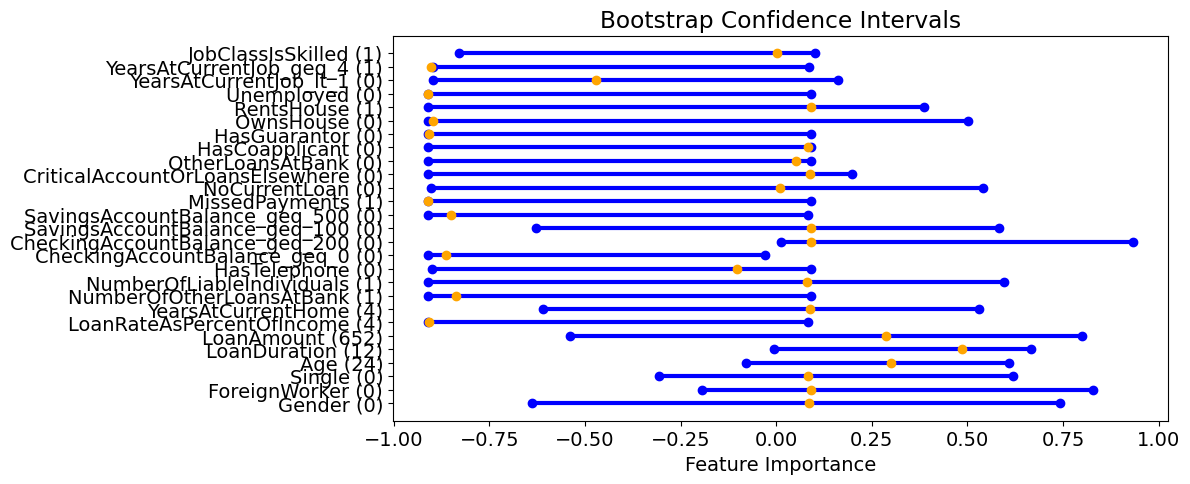

In [64]:
samples_in = np.copy(X)
samples_out = ground_truth(X) # probabilities predicted by the model

deltas = {3:5, 4:5, 5:1000, 6:1, 7:1, 8:1, 9:1} # maps continuous features to the deltas we should use to compute function differences

bte = BootstrapTabularExplainer(data=samples_in, 
                                model_outputs=samples_out, 
                                mode='classification', 
                                feature_names=feature_names, 
                                categorical_features=categorical_features,
                                explanation_type='diffs', 
                                deltas=deltas
                               )

explanation = bte.explain_instance(query, m=M, k=K, verbose=True, with_confidence=True, boot_ratio=0.9)

## Meta explanations

In [7]:
# Construct explanations for all points in the dataset (takes a while)
all_explanations = [None for i in range(len(X_test))]

for i in range(len(X_test)):
    print(i, end='\r')
    query = X_test[i,:]
    explanation = bte.explain_instance(query, m=M, k=K, verbose=False, with_confidence=True, boot_ratio=0.9)
    all_explanations[i] = explanation

In [8]:
# Compute average feature importances scores and average interval widths over all points in the dataset
num_explanations = len(all_explanations)
scores = [0 for i in range(num_features)]
widths = [0 for i in range(num_features)]

for explanation in all_explanations:
    for i in range(len(explanation)):
        scores[i] += np.abs(explanation[i]['importance'])/num_explanations
        widths[i] += (explanation[i]['upper_confidence'] - explanation[i]['lower_confidence'])/num_explanations

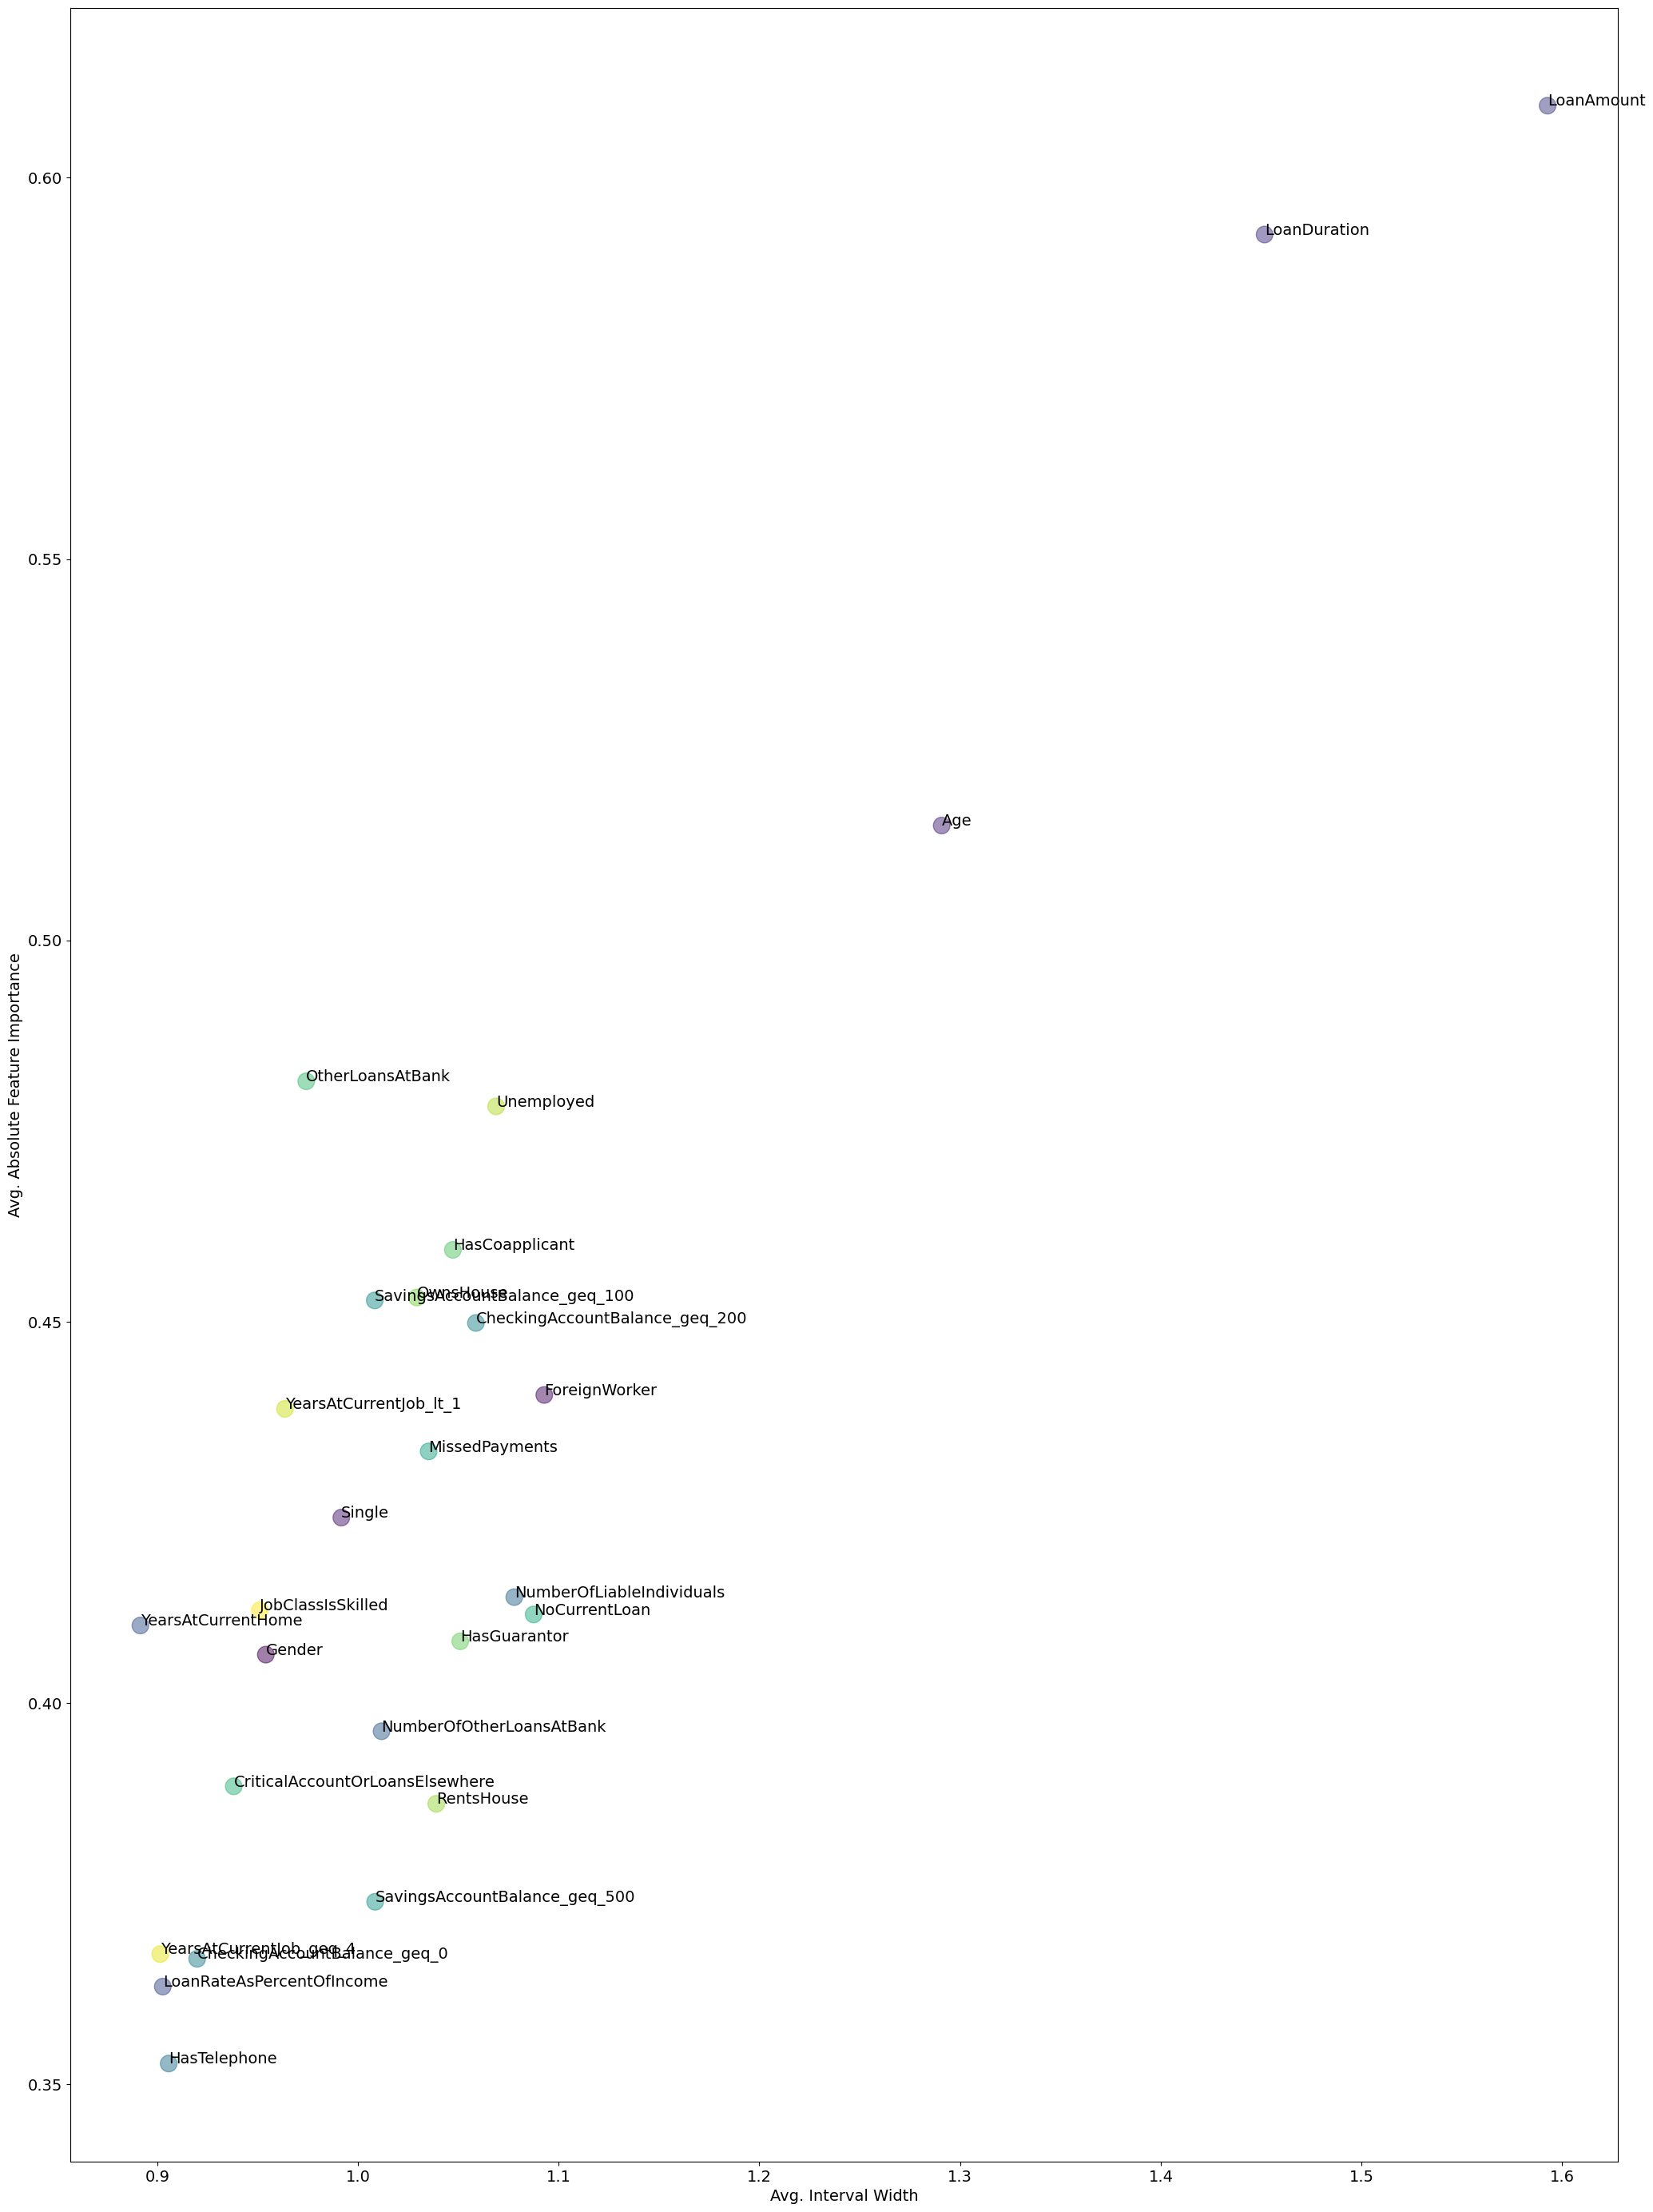

In [9]:
# Scatterplot of avg. feature importances and avg. interval widths
area = (30 * 0.5)**2  
colors = np.linspace(0,1,num_features)
fig, ax = plt.subplots()
ax.scatter(widths, scores, s=area, c=colors, alpha=0.5)
for i, txt in enumerate(feature_names):
    ax.annotate(txt, (widths[i], scores[i]))
plt.xlabel("Avg. Interval Width")
plt.ylabel("Avg. Absolute Feature Importance")
fig.set_figwidth(25)
fig.set_figheight(35)
plt.show()

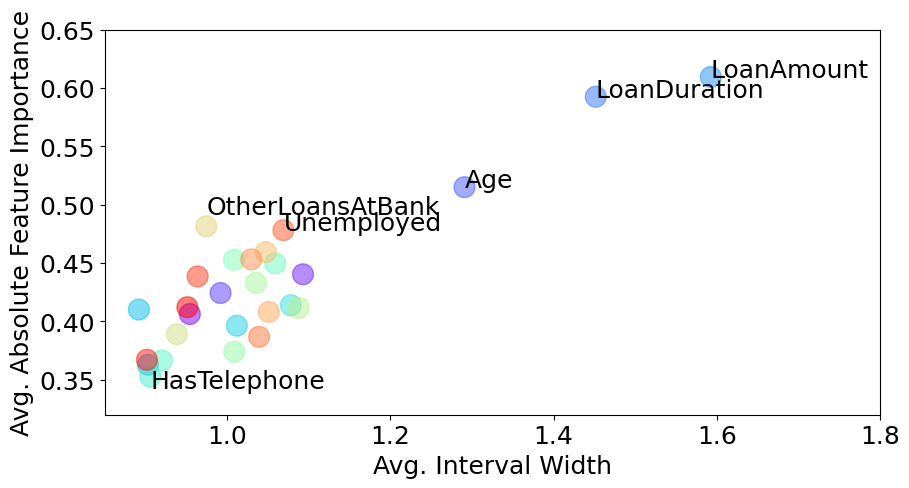

In [10]:
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 18})

# Scatterplot of avg. feature importances and avg. interval widths
area = (30 * 0.5)**2  
colors = cm.rainbow(np.linspace(0, 1, num_features))
fig, ax = plt.subplots()
ax.scatter(widths, scores, s=area, c=colors, alpha=0.5)
for i, txt in enumerate(feature_names):
    if txt=='Age' or txt=='LoanDuration' or txt=='LoanAmount' or txt=='Unemployed':
        ax.annotate(txt, (widths[i], scores[i]))
    if txt=='OtherLoansAtBank':
        ax.annotate(txt, (widths[i], scores[i]+0.01))
    if txt=='HasTelephone':
        ax.annotate(txt, (widths[i], scores[i]-0.01))
plt.xlabel("Avg. Interval Width")
plt.ylabel("Avg. Absolute Feature Importance")
plt.xlim([0.85, 1.8])
plt.ylim([0.32,.65])
plt.savefig('figs/german-credit.png', bbox_inches='tight')
plt.show()